# Introduction to Time Series Forecasting
## Autoregressive Models & Smoothing Methods

For a more detailed breakdown of the theory behind the code, check out the [full article](https://blog.paperspace.com/time-series-forecasting-autoregressive-models-smoothing-methods/) on the Paperspace blog.

In [10]:
## Already installed on this container
# !pip install pmdarima

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

df = pd.read_csv('jena_climate_2009_2016.csv')

time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
series = df['T (degC)'][5::6]
series.index = time[5::6]

In [12]:
import pandas as pd
import pmdarima as pm
import pickle

df = pd.read_csv('jena_climate_2009_2016.csv')

series = df['T (degC)'][4391::4392]
time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')[4391::4392]
series.index = time

train = series[:-int(len(series)/10)]
test = series[-int(len(series)/10):]


model = pm.auto_arima(train.values, 
                      start_p=1, # lag order starting value
                      start_q=1, # moving average order starting value
                      test='adf', #ADF test to decide the differencing order
                      max_p=3, # maximum lag order
                      max_q=3, # maximum moving average order
                      m=12, # seasonal frequency
                      d=None, # None so that the algorithm can chose the differencing order depending on the test
                      seasonal=True, 
                      start_P=0, 
                      D=1, # enforcing the seasonal frequencing with a positive seasonal difference value
                      trace=True,
                      suppress_warnings=True, 
                      stepwise=True)


print(model.summary())

# save the model
with open('seasonal_o.pkl', 'wb') as f:
    pickle.dump(model, f)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=470.845, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=495.164, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=476.897, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=469.206, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=493.179, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=489.549, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=476.803, Time=0.09 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=472.626, Time=0.10 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=470.997, Time=0.22 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=468.858, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=490.050, Time=0.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=in

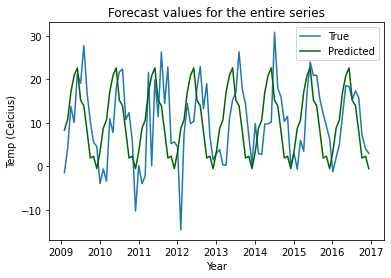

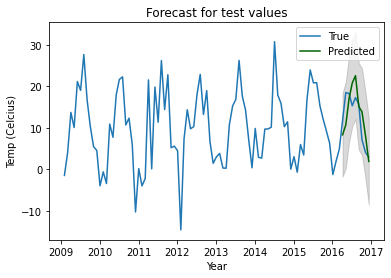

In [13]:
import matplotlib.pyplot as plt

# predictions for the entire series 
all_vals = model.predict(n_periods=len(series), return_conf_int=False)
all_vals = pd.Series(all_vals, index=series.index)
plt.plot(series)
plt.plot(all_vals, color='darkgreen')
plt.title('Forecast values for the entire series')
plt.xlabel('Year')
plt.ylabel('Temp (Celcius)')
plt.legend(['True', 'Predicted'])
plt.show()

# predictions for the test set with confidence values
preds, conf_vals = model.predict(n_periods=len(test), return_conf_int=True)
preds = pd.Series(preds, index=test.index)

lower_bounds = pd.Series(conf_vals[:, 0], index=list(test.index))
upper_bounds = pd.Series(conf_vals[:, 1], index=list(test.index))

plt.plot(series)
plt.plot(preds, color='darkgreen')
plt.fill_between(lower_bounds.index, 
                 lower_bounds, 
                 upper_bounds, 
                 color='k', alpha=.15)

plt.title("Forecast for test values")
plt.xlabel('Year')
plt.ylabel('Temp (Celcius)')
plt.legend(['True', 'Predicted'])
plt.show()

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

def exponential_smoothing(df, smoothing_level=0.2):
    model = SimpleExpSmoothing(np.asarray(df))
    model._index = pd.to_datetime(df.index)
    fit = model.fit(smoothing_level=smoothing_level)   
    return fit

def holts_linear_smoothing(df, smoothing_level=0.3, smoothing_slope=0.05):
    model = Holt(np.asarray(df))
    model._index = pd.to_datetime(df.index)
    fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)   
    return fit
    
def holts_exponential_smoothing(df, trend=None, damped=False, seasonal=None, seasonal_periods=None):
    model = ExponentialSmoothing(np.asarray(df), trend=trend, seasonal=seasonal, damped=damped, seasonal_periods=seasonal_periods)
    model._index = pd.to_datetime(df.index)
    fit = model.fit()
    return fit

In [15]:
import numpy as np

def smoothing_experiments(train, test, params, method):
    methods = ['simpl_exp', 'holts_lin', 'holts_exp']
    models = {}
    preds = {}
    rmse = {}
    if method == methods[0]:
        for s in params['smoothing_level']:
            models[s] = exponential_smoothing(train, smoothing_level=s)
            preds[s] = models[s].predict(start=1,end=len(test))
            preds[s] -= preds[s][0]
            preds[s] += train.values[-1]
            rmse[s] = np.sqrt(mean_squared_error(test, preds[s]))
    elif method == methods[1]:
        for sl in params['smoothing_level']:
            for ss in params['smoothing_trend']:
                models[(sl,ss)] = holts_linear_smoothing(train, smoothing_level=sl, smoothing_slope=ss)
                preds[(sl,ss)] = models[(sl,ss)].predict(start=1,end=len(test))                
                preds[(sl,ss)] -= preds[(sl,ss)][0]
                preds[(sl,ss)] += train.values[-1]
                rmse[(sl,ss)] = np.sqrt(mean_squared_error(test, preds[(sl,ss)]))
    elif method == methods[2]:
        for t in params['trend']:
            for d in params['damped_trend']:
                models[(t,d)] = holts_exponential_smoothing(train, trend=t, damped=d)
                preds[(t,d)] = models[(t,d)].predict(start=1,end=len(test))
                preds[(t,d)] -= preds[(t,d)][0]
                preds[(t,d)] += train.values[-1]
                rmse[(t,d)] = np.sqrt(mean_squared_error(test, preds[(t,d)]))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train.index, train.values, color="gray", label='train original')
    ax.plot(test.index, test.values, color="gray", label='test original')
    for p, f, r in zip(list(preds.values()),list(models.values()),list(rmse.values())):
        if method == methods[0]:
            ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3]+" RMSE: "+str(r))
            ax.set_title("Simple Exponential Smoothing")    
            ax.legend();
        elif method == methods[1]:
            ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+" RMSE: "+str(r))
            ax.set_title("Holts Linear Smoothing")    
            ax.legend();
        elif method == methods[2]:
            ax.plot(test.index, p, 
                    label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False)+" RMSE: "+str(r), 
                    )
            ax.set_title("Holts Exponential Smoothing")    
            ax.legend();
    plt.show()
    return models, preds, rmse


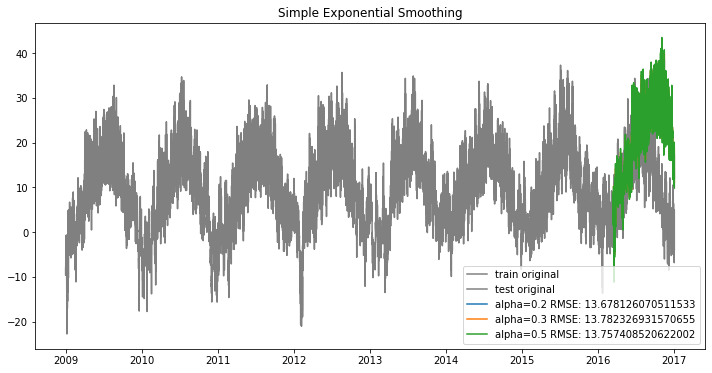

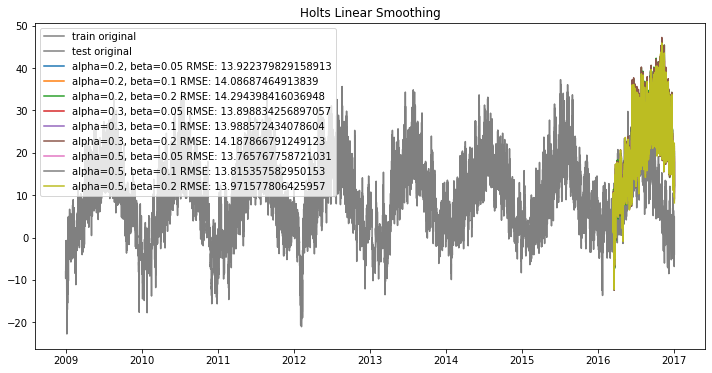

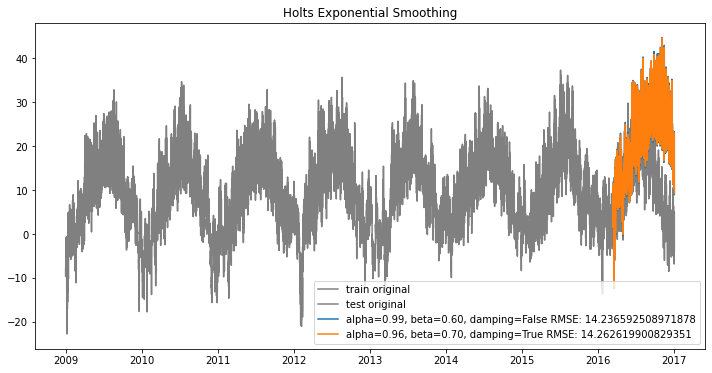

In [16]:
# defining the parameters for hyperparameter search
simpl_exp_params = {
    'smoothing_level': [0.2, 0.3, 0.5],
}

holts_lin_params = {
    'smoothing_level': [0.2, 0.3, 0.5],
    'smoothing_trend': [0.05, 0.1, 0.2],
}

holts_exp_params = {
    'trend': ['add'],
    'damped_trend': [False, True],
}

df = pd.read_csv('jena_climate_2009_2016.csv')

series = df['T (degC)'][5::6]
time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')[5::6]
series.index = time

train = series[:-int(len(series)/10)]
test = series[-int(len(series)/10):]


simpl_exp_models, simpl_exp_preds, simpl_exp_rmse = smoothing_experiments(train, test, simpl_exp_params, 'simpl_exp')
holts_lin_models, holts_lin_preds, holts_lin_rmse = smoothing_experiments(train, test, holts_lin_params, 'holts_lin')
holts_exp_models, holts_exp_preds, holts_exp_rmse = smoothing_experiments(train, test, holts_exp_params, 'holts_exp')

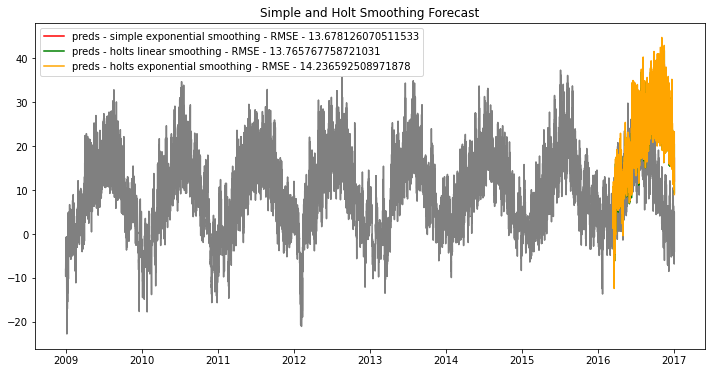

In [17]:
# find the best model based on the RMSE values
def get_best_model(rmse):
    min_rmse = min(rmse.values())
    best = [key for key in rmse if rmse[key] == min_rmse]
    return best[0]

best1 = get_best_model(simpl_exp_rmse)
best2 = get_best_model(holts_lin_rmse)
best3 = get_best_model(holts_exp_rmse)

# get plots for all the exponential smoothing best models
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, color='gray')
plt.plot(test.index, test.values, color='gray')
plt.title('Simple and Holt Smoothing Forecast')

preds = simpl_exp_preds[best1]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='red', label='preds - simple exponential smoothing - RMSE - {}'.format(rmse))
plt.legend()

preds = holts_lin_preds[best2]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='green', label='preds - holts linear smoothing - RMSE - {}'.format(rmse))
plt.legend()

preds = holts_exp_preds[best3]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='orange', label='preds - holts exponential smoothing - RMSE - {}'.format(rmse))
plt.legend()

plt.show()

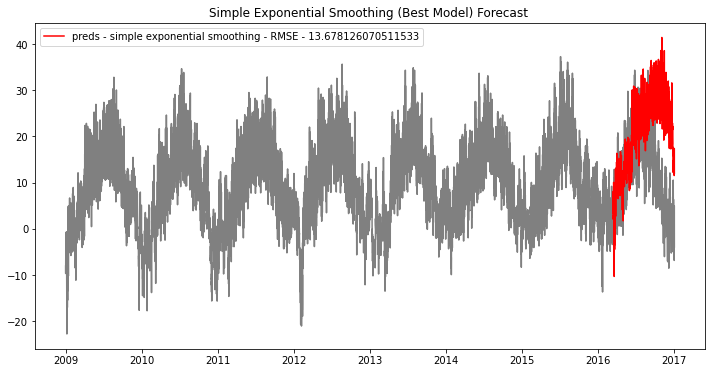

In [18]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, color='gray')
plt.plot(test.index, test.values, color='gray')
plt.title('Simple Exponential Smoothing (Best Model) Forecast ')

preds = simpl_exp_preds[best1]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='red', label='preds - simple exponential smoothing - RMSE - {}'.format(rmse))
plt.legend()
plt.show()